In [1]:
import numpy as np
import xarray as xr
import rioxarray as rxr
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

In [2]:
# Load preprocessed dataset (DOP with forest_mask)
filepath = 'D:/COPY/Projekt_FF/Process/dop_forestmask.nc'
dop = rxr.open_rasterio(filepath)
dop = dop.squeeze()
dop

<xarray.Dataset>
Dimensions:              (x: 10000, y: 10000)
Coordinates:
    band                 int32 1
  * x                    (x) float64 4.68e+05 4.68e+05 ... 4.69e+05 4.69e+05
  * y                    (y) float64 5.672e+06 5.672e+06 ... 5.671e+06 5.671e+06
    transverse_mercator  int32 0
    spatial_ref          int32 0
Data variables:
    Band1                (y, x) uint8 ...
    Band2                (y, x) uint8 ...
    Band3                (y, x) uint8 ...
    Band4                (y, x) uint8 ...
    forest_mask          (y, x) uint8 ...
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 3.5.3, released 2022/10/21
    history:      Tue Nov 08 15:47:04 2022: GDAL CreateCopy( D:/COPY/Projekt_...

### **U-Net approach**
Define the model using a pretrained model (MobileNetV2). The following steps are based on the [TensorFlow tutorial on image segmentation](https://www.tensorflow.org/tutorials/images/segmentation).

In [3]:
# Split DOP into tiles
# Define tile size
tilesize = 224

In [4]:
# Define data generator for the model
# Tiles the dataset into multiple tiles and returns them in batches (row-wise)
# Also splits the data into training/validation/test
class CustomImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, ds, sampletype, tilesize=tilesize):
        self.ds   = ds
        self.ylen = self.ds.y.size // tilesize
        self.xlen = self.ds.x.size // tilesize
        self.sampletype = sampletype
        
    def __len__(self):
        return self.ylen

    def __getitem__(self, index):
        
        red       = self.ds.Band1[index*tilesize:(index+1)*tilesize,:-(self.ds.x.size%tilesize)]
        green     = self.ds.Band2[index*tilesize:(index+1)*tilesize,:-(self.ds.x.size%tilesize)]
        blue      = self.ds.Band3[index*tilesize:(index+1)*tilesize,:-(self.ds.x.size%tilesize)]
        forest    = self.ds.forest_mask[index*tilesize:(index+1)*tilesize,:-(self.ds.x.size%tilesize)]
        
        rgb       = np.array([red,green,blue]).transpose(1,2,0)
        forest    = np.array(forest)
        
        rgb_tiles    = np.array(np.split(rgb, self.xlen,axis=1))
        target_tiles = np.array(np.split(forest, self.xlen,axis=1))
        
        # Depending on sampletype, return training, validation or test set (complete set)
        if self.sampletype == 'training' or self.sampletype == 'validation':
            rgb_tiles_tr, rgb_tiles_val, target_tiles_tr, target_tiles_val = train_test_split(rgb_tiles, target_tiles, shuffle=True, test_size=0.1, random_state=0)
            if self.sampletype == 'training': return rgb_tiles_tr, target_tiles_tr
            else:                             return rgb_tiles_val, target_tiles_val
        
        if self.sampletype == 'test': return rgb_tiles, target_tiles
        
        return None

In [6]:
# Load pretrained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(input_shape=[tilesize, tilesize, 3], include_top=False)

# Overview of the model architecture
# Switch 'button' to True for printing
button = False

if button == True:
    print(base_model.summary())
else:
    pass

In [7]:
# Modify the model
# First the downstack/downsampler

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

# We make this part of the model fix (not trainable)
down_stack.trainable = False

In [8]:
# Upstack/Upsampler
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [9]:
# Define modified U-Net
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[tilesize, tilesize, 3])
    x = inputs
    
    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [10]:
# Compile the model with 2 output channels/classes
OUTPUT_CHANNELS = 2

model = unet_model(output_channels=OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
# Plot the resulting model architecture
# Switch 'button' to True for printing
button = True

if button == True:
    tf.keras.utils.plot_model(model, show_shapes=True)
else:
    pass

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
# Create an instance of previously defined data generator
# Hand over the training data (DOP with forest_mask)
cidg_training   = CustomImageDataGenerator(dop, sampletype='training')
cidg_validation = CustomImageDataGenerator(dop, sampletype='validation')

In [13]:
# Function to display exemplary data
def plotExample(dataGen, batch_id, tile_id):
    batch = dataGen.__getitem__(batch_id)
    predi = model.predict(batch[0])
    
    fig, ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(batch[0][tile_id]); ax[0].set_title('RGB input')
    ax[1].imshow(batch[1][tile_id], cmap='Greys', interpolation='None'); ax[1].set_title('True mask')
    ax[2].imshow(np.argmax(predi[tile_id], axis=-1), cmap='Greys', interpolation='None'); ax[2].set_title('Prediction')
    plt.show()
    
    return

2/2 [==============================] - 3s 322ms/step


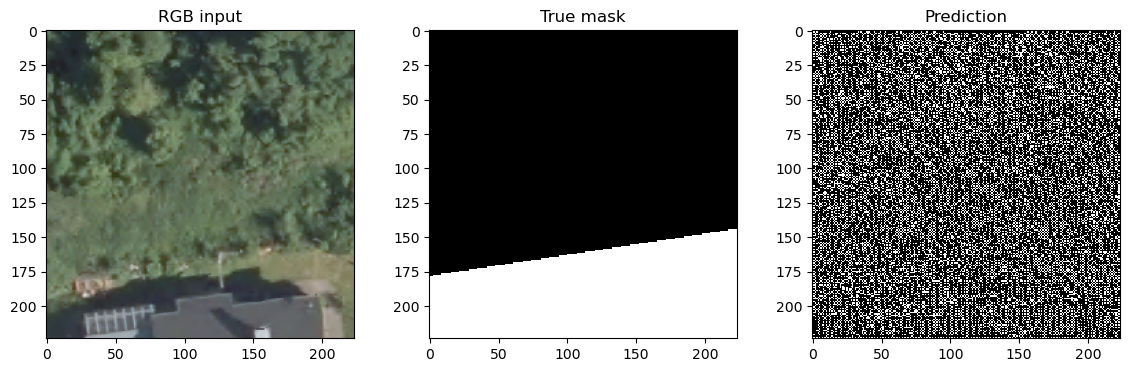

In [14]:
plotExample(cidg_training, 10, 17)
plotExample(cidg_validation, 10, 3)

### Model training

In [16]:
model_history = model.fit(cidg_training,
                          validation_data=cidg_validation,
                          epochs=20,
                          initial_epoch=0)

Epoch 1/20
44/44 [==============================] - 153s 3s/step - loss: 0.6541 - accuracy: 0.6698 - val_loss: 1.2080 - val_accuracy: 0.5748
Epoch 2/20
44/44 [==============================] - 164s 4s/step - loss: 0.5466 - accuracy: 0.7469 - val_loss: 3.8299 - val_accuracy: 0.4725
Epoch 3/20
44/44 [==============================] - 159s 4s/step - loss: 0.5031 - accuracy: 0.7789 - val_loss: 1.3290 - val_accuracy: 0.6747
Epoch 4/20
44/44 [==============================] - 159s 4s/step - loss: 0.4714 - accuracy: 0.7926 - val_loss: 0.6437 - val_accuracy: 0.8224
Epoch 5/20
44/44 [==============================] - 158s 4s/step - loss: 0.4859 - accuracy: 0.7876 - val_loss: 1.0422 - val_accuracy: 0.6992
Epoch 6/20
44/44 [==============================] - 158s 4s/step - loss: 0.4294 - accuracy: 0.8140 - val_loss: 0.5692 - val_accuracy: 0.8180
Epoch 7/20
44/44 [==============================] - 159s 4s/step - loss: 0.4175 - accuracy: 0.8273 - val_loss: 0.4243 - val_accuracy: 0.8560
Epoch 8/20
44

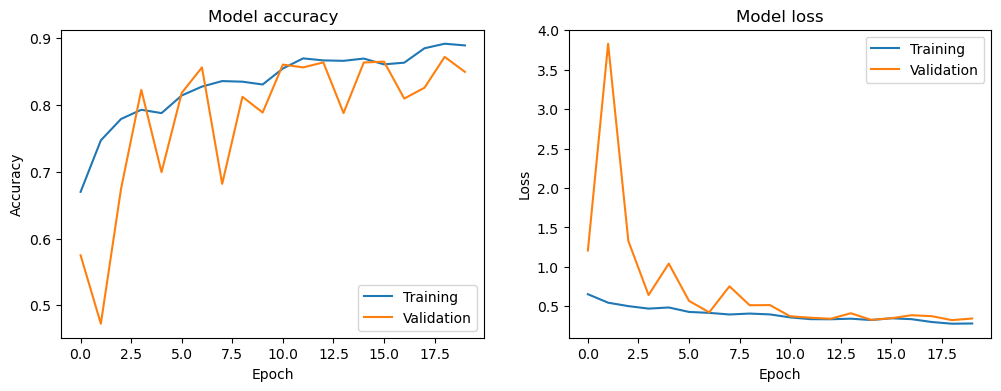

In [20]:
# Plot accuracy and loss over the epochs
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(model_history.history['accuracy'])
ax[0].plot(model_history.history['val_accuracy'])
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training', 'Validation'], loc='lower right')

ax[1].plot(model_history.history['loss'])
ax[1].plot(model_history.history['val_loss'])
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training', 'Validation'], loc='upper right')

plt.show()

### Example predictions

2/2 [==============================] - 2s 312ms/step


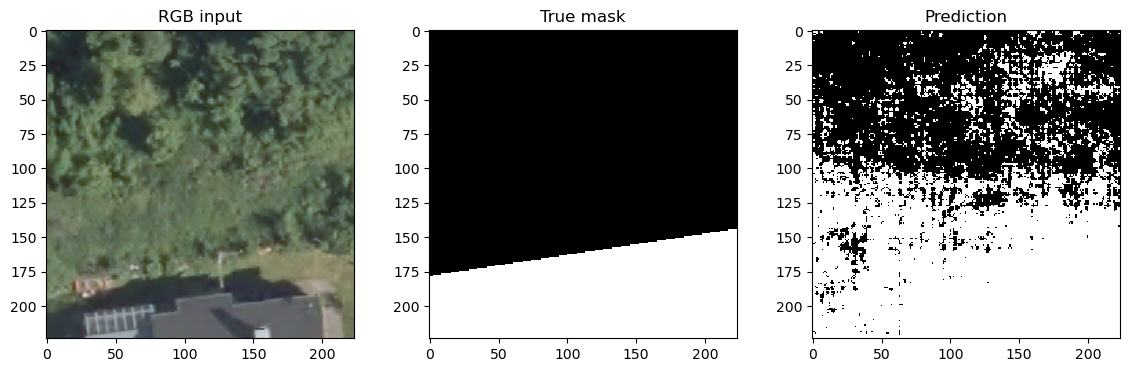

1/1 [==============================] - 0s 232ms/step


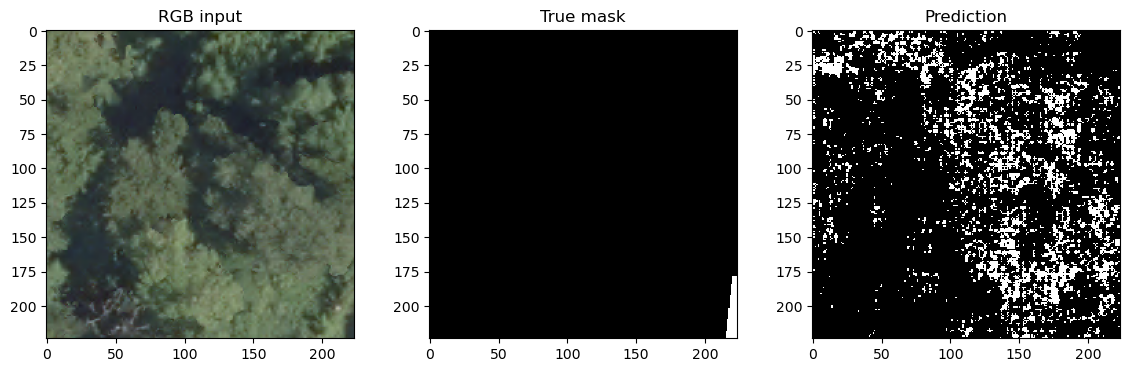

In [22]:
plotExample(cidg_training, 10, 17)
plotExample(cidg_validation, 10, 3)

In [23]:
# Save trainend model
model.save('D:/COPY/Projekt_FF/Process//UNet_forest')

INFO:tensorflow:Assets written to: D:/COPY/Projekt_FF/Process//UNet_forest\assets


INFO:tensorflow:Assets written to: D:/COPY/Projekt_FF/Process//UNet_forest\assets
